In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopy
from geopy import distance
from geopy.distance import vincenty
# from tqdm import tqdm
# tqdm.pandas()
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
import numpy as np

import eli5
from eli5.sklearn import PermutationImportance
# from skopt.space import Real
import matplotlib.colors as clt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Using TensorFlow backend.
C:\Users\lorie\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\lorie\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
train = pd.read_csv('listings.csv.gz', compression='gzip')
price_df = pd.read_csv('listings.csv')


In [3]:
# train.head()

In [4]:

lon = -90.0680352
lat = 29.9585246
train['distance_center'] = train.apply(lambda x: vincenty((x['latitude'], x['longitude']), (lat, lon)).miles, axis = 1)




In [5]:
train['price']=(train['price'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['cleaning_fee']=(train['cleaning_fee'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
train['security_deposit']=(train['security_deposit'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
sample = train.sample(1000, random_state=42)
bins= [0,50,100,150,200,250,300,350,400,450,500,10000]
labels = ['$50','$100','$150','$200','$250','$300','$350','$400','$450','$500', '$10000']
# sample['price'] = pd.cut(sample['price'], bins=bins, labels=labels)
train['price'].head()


0    300.0
1    100.0
2    125.0
3    115.0
4     50.0
Name: price, dtype: float64

In [6]:
train.head()
cleanmean=train['cleaning_fee'].dropna().mean()
train['cleaning_fee']=train['cleaning_fee'].fillna(cleanmean)
train['square_feet']=train['square_feet'].fillna(train['square_feet'].dropna().mean())
train['price']=train['price'].fillna(train['price'].dropna().mean())
train['bathrooms']=train['bathrooms'].fillna(train['bathrooms'].dropna().mean())
train['bedrooms']=train['bedrooms'].fillna(train['bedrooms'].dropna().mean())
train['beds']=train['beds'].fillna(train['beds'].dropna().mean())
train['square_feet']=train['square_feet'].fillna(train['square_feet'].dropna().mean())
train['security_deposit']=train['security_deposit'].fillna(train['security_deposit'].dropna().mean())

In [7]:
train['price'].max()

8000.0

In [8]:
df = train.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review', 'reviews_per_month'])
label_encoder=LabelEncoder()
label_encoder.fit(df['neighbourhood_cleansed'])
df['neighbourhood_cleansed']=label_encoder.transform(df['neighbourhood_cleansed'])
# label_encoder.fit(df['price'])
# df['price']=label_encoder.transform(df['price'])

label_encoder.fit(df['square_feet'])
df['square_feet']=label_encoder.transform(df['square_feet'])
label_encoder.fit(df['property_type'])
df['property_type']=label_encoder.transform(df['property_type'])
label_encoder.fit(df['room_type'])
df['room_type']=label_encoder.transform(df['room_type'])
label_encoder.fit(df['distance_center'])
df['distance_center']=label_encoder.transform(df['distance_center'])
label_encoder.fit(df['cleaning_fee'])
df['cleaning_fee']=label_encoder.transform(df['cleaning_fee'])
label_encoder.fit(df['bathrooms'])
df['bathrooms']=label_encoder.transform(df['bathrooms'])
label_encoder.fit(df['bedrooms'])
df['bedrooms']=label_encoder.transform(df['bedrooms'])
label_encoder.fit(df['beds'])
df['beds']=label_encoder.transform(df['beds'])
label_encoder.fit(df['host_listings_count'])
df['host_listings_count']=label_encoder.transform(df['host_listings_count'])
label_encoder.fit(df['security_deposit'])
df['security_deposit']=label_encoder.transform(df['security_deposit'])
label_encoder.fit(df['guests_included'])
df['guests_included']=label_encoder.transform(df['guests_included'])
label_encoder.fit(df['number_of_reviews'])
df['number_of_reviews']=label_encoder.transform(df['number_of_reviews'])

In [9]:
df['price'].max()

8000.0

In [10]:

# bins1 = [48,100, 150, 250,300,350]
# labels1 = [1,2,3,4, 5]
# # train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1).astype('int')
# df['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)

In [11]:
test = pd.DataFrame({
    'Hood': df['neighbourhood_cleansed'],
    'SqFt':df['square_feet'],
    '#Reviews':df['number_of_reviews'],
    '#Guests':df['guests_included'],
    'Listing Count':df['host_listings_count'],
    'Security':df['security_deposit'],
    'CleanFee':df['cleaning_fee'],
    'Dist':df['distance_center'],
#     'Room':df['room_type'],
    'BA':df['bathrooms'], 
#     'Prop':df['property_type'],
    'BR':df['bedrooms'], 
    'Beds': df['beds'],
    'Acc':df['accommodates'],
    'Price':df['price']
})

# train1 = train.dropna()
test.to_csv('test1_data.csv')
# train1['Hood'].unique

In [12]:
df1 = df.groupby(['neighbourhood_cleansed']).mean()
price_grouped = price_df.groupby(['neighbourhood']).mean()
price = price_grouped['price']
# df.head()
df1.head()

,host_acceptance_rate,host_listings_count,host_total_listings_count,property_type,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,distance_center
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,2.622951,7.606557,12.803279,0.114754,4.262295,2.213115,2.540984,3.065574,19.950820,140.786885,15.163934,55.245902,1.540984,2.147541,612.426230,2.016393,2.409836,612.426230,612.426230,2.178689,612.426230,6.540984,17.836066,35.147541,173.114754,50.180328,23.426230,97.754386,9.877193,9.842105,9.982456,9.912281,9.824561,9.859649,2.491803,2.344262,0.147541,0.0,2149.278689
1,NaN,2.540984,5.032787,13.286885,0.180328,4.770492,2.663934,2.598361,3.147541,19.868852,240.122951,18.319672,60.778689,1.786885,3.745902,610.745902,3.713115,4.040984,610.745902,610.745902,3.770492,610.745902,9.524590,22.803279,41.663934,155.598361,37.631148,17.918033,97.214286,9.883929,9.758929,9.982143,9.964286,9.919643,9.732143,2.254098,1.836066,0.418033,0.0,5931.852459
2,NaN,2.825758,5.128788,12.992424,0.098485,4.280303,2.090909,2.348485,2.742424,20.068182,182.477273,16.916667,53.143939,1.151515,3.159091,666.537879,2.893939,3.681818,637.446970,655.022727,3.228030,637.772727,7.446970,18.204545,36.886364,139.772727,36.719697,14.628788,97.904000,9.928000,9.856000,9.976000,9.984000,9.736000,9.864000,2.621212,2.416667,0.204545,0.0,2986.962121
3,NaN,1.166667,1.166667,19.750000,0.083333,4.666667,2.166667,2.833333,2.916667,20.000000,122.750000,9.250000,52.750000,1.166667,1.916667,541.166667,1.916667,2.083333,541.166667,541.166667,1.975000,541.166667,9.916667,28.333333,52.583333,185.583333,15.166667,10.000000,94.888889,9.666667,9.555556,10.000000,10.000000,9.555556,9.777778,1.166667,1.083333,0.083333,0.0,5211.416667
4,NaN,3.655172,14.137931,14.448276,0.275862,3.655172,1.793103,2.241379,2.344828,20.000000,147.862069,13.793103,50.103448,1.206897,4.068966,571.413793,4.034483,4.275862,571.413793,571.413793,4.086207,571.413793,6.862069,17.344828,32.586207,145.551724,45.724138,18.413793,96.923077,9.923077,9.769231,10.000000,9.884615,9.846154,9.730769,3.206897,2.827586,0.379310,0.0,6301.448276


In [13]:
df1['price'].head()
# price.head()

neighbourhood_cleansed
0    140.786885
1    240.122951
2    182.477273
3    122.750000
4    147.862069
Name: price, dtype: float64

In [14]:
price_high = df1.loc[(df1['price']>=225)]
price_mid = df1[(df1['price']>150) & (df1['price'] <225)]
price_low = df1[(df1['price']>=0) & (df1['price'] <150)]
price_all = df1[df1['price']>1]
p_low = price_low.reset_index()
p_mid = price_mid.reset_index()
p_high = price_high.reset_index()
p_all = price_all.reset_index()

In [15]:
def bar_price(feature, index):
    fig, ax = plt.subplots()
    x_axis = np.arange(len(feature['price']))
    ax.bar(x_axis, feature['price'])
    labels =index['neighbourhood_cleansed']
    ax.set_xticks(x_axis)
    ax.set_xticklabels(labels, rotation=90, ha="right")

In [16]:

# bar_price(price_all, p_all)
# bar_price(price_low, p_low)
# bar_price(price_mid, p_mid)
# bar_price(price_high, p_high)

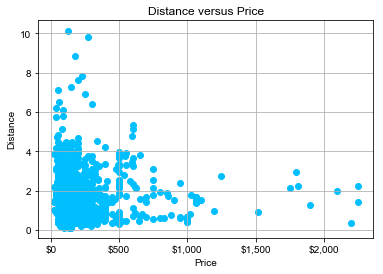

In [17]:
a = "#000080"
b = "#00BFFF"
c = "#32cd32"
d = "#FF4500"
clt.to_hex(a)
clt.to_hex(b)
clt.to_hex(c)
clt.to_hex(d)

price = sample['price']
dist = sample['distance_center']
fig, ax = plt.subplots()
ax.scatter(price,dist, color=b)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))


plt.style.use('seaborn')
plt.title('Distance versus Price')
plt.xlabel('Price')
plt.ylabel('Distance')
plt.grid()

plt.show()

In [18]:
# df = df.replace([np.inf, -np.inf], np.nan)
df = df.reset_index()
df.columns

Index(['index', 'space', 'description', 'experiences_offered', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_a

In [19]:
df['price'].min()

15.0

In [20]:

# df = df.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review', 'reviews_per_month'])


train1 = pd.DataFrame({
    'Hood': df['neighbourhood_cleansed'],
    'SqFt':df['square_feet'],
    '#Reviews':df['number_of_reviews'],
    '#Guests':df['guests_included'],
    'Listing Count':df['host_listings_count'],
    'Security':df['security_deposit'],
    'CleanFee':df['cleaning_fee'],
    'Dist':df['distance_center'],
#     'Room':df['room_type'],
    'BA':df['bathrooms'], 
#     'Prop':df['property_type'],
    'BR':df['bedrooms'], 
    'Beds': df['beds'],
    'Acc':df['accommodates'],
    'Price':df['price']
})
# train1=train1[:-1]
# train1['Price']

In [21]:

bins1 = [0,50,100, 150, 250,300,400, 600, 1000, 8000]
labels1 = [1,2,3,4, 5, 6,7, 8, 9]
# train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1).astype('int')
train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)

train1.to_csv('test_data.csv')
# train1['Hood'].unique

In [22]:
train1.head()

,Hood,SqFt,#Reviews,#Guests,Listing Count,Security,CleanFee,Dist,BA,BR,Beds,Acc,Price
0,43,20,96,3,1,0,71,5591,4,4,4,4,5
1,33,15,288,1,1,0,40,5502,1,1,1,3,2
2,37,20,215,1,2,18,57,1630,1,1,1,2,3
3,54,20,133,1,2,0,49,3622,4,1,1,2,3
4,6,20,179,1,2,15,34,4571,1,1,1,2,1


In [23]:


from sklearn.preprocessing import StandardScaler

x = train1.drop('Price', axis=1)
y = train1['Price']
print(x.shape, y.shape)


(6632, 12) (6632,)


In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, stratify=y)

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)
# y_scaler = StandardScaler()
# encoded_y_train = (y_train)
# encoded_y_test = (y_test)


# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)
print(x_train_scaled.shape, y_train_categorical.shape)
print(x_test_scaled.shape, y_test_categorical.shape)


(3316, 12) (3316, 9)
(3316, 12) (3316, 9)


In [25]:
clf = KNeighborsClassifier(n_neighbors = 5)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.37696578167875117


In [26]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.43049028693961366


In [27]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.501961920078504


In [28]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.29086072797979245


In [29]:
# clf = SVC()
# scoring = 'accuracy'
# score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

# print(score.mean())

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create model and add layers
model = Sequential()
model.add(Dense(units=100, activation='relu',input_dim=x_train_scaled.shape[1]))
# model.add(Dense(units=1000, activation='softmax'))
model.add(Dense(units=100, activation='relu'))

model.add(Dense(units=y_train_categorical.shape[1], activation='softmax'))
# model.add(Flatten())
# model.add(Dense(units=2, activation='softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               1300      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 12,309
Trainable params: 12,309
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(
#                 optimizer='adam',
                optimizer='adadelta',
#               loss='categorical_crossentropy',
              loss='mse',
#                  metrics=['mean_squared_error', 'mean_absolute_error'])
              metrics=['accuracy'])
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])


In [32]:
model.fit(
    x_train_scaled,
    y_train_categorical,
    epochs=100,
#     batch_size=100,
    shuffle=True,
    verbose=2
)



Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
 - 0s - loss: 0.0896 - acc: 0.3221
Epoch 2/1000
 - 0s - loss: 0.0823 - acc: 0.3890
Epoch 3/1000
 - 0s - loss: 0.0803 - acc: 0.4083
Epoch 4/1000
 - 0s - loss: 0.0791 - acc: 0.4180
Epoch 5/1000
 - 0s - loss: 0.0780 - acc: 0.4406
Epoch 6/1000
 - 0s - loss: 0.0772 - acc: 0.4397
Epoch 7/1000
 - 0s - loss: 0.0765 - acc: 0.4439
Epoch 8/1000
 - 0s - loss: 0.0758 - acc: 0.4533
Epoch 9/1000
 - 0s - loss: 0.0753 - acc: 0.4572
Epoch 10/1000
 - 0s - loss: 0.0748 - acc: 0.4548
Epoch 11/1000
 - 0s - loss: 0.0743 - acc: 0.4626
Epoch 12/1000
 - 0s - loss: 0.0740 - acc: 0.4695
Epoch 13/1000
 - 0s - loss: 0.0736 - acc: 0.4698
Epoch 14/1000
 - 0s - loss: 0.0732 - acc: 0.4747
Epoch 15/1000
 - 0s - loss: 0.0730 - acc: 0.4726
Epoch 16/1000
 - 0s - loss: 0.0727 - acc: 0.4810
Epoch 17/1000
 - 0s - loss: 0.0722 - acc: 0.4858
Epoch 18/1000
 - 0s - loss: 0.0719 - acc: 0.4849
Epoch 19/1000
 - 0s - loss: 0.0717 - acc: 0.4922
Epoch 20/1000
 - 0s - loss: 0.

Epoch 162/1000
 - 0s - loss: 0.0439 - acc: 0.7346
Epoch 163/1000
 - 0s - loss: 0.0436 - acc: 0.7358
Epoch 164/1000
 - 0s - loss: 0.0434 - acc: 0.7403
Epoch 165/1000
 - 0s - loss: 0.0431 - acc: 0.7400
Epoch 166/1000
 - 0s - loss: 0.0438 - acc: 0.7334
Epoch 167/1000
 - 0s - loss: 0.0427 - acc: 0.7413
Epoch 168/1000
 - 0s - loss: 0.0428 - acc: 0.7419
Epoch 169/1000
 - 0s - loss: 0.0425 - acc: 0.7521
Epoch 170/1000
 - 0s - loss: 0.0427 - acc: 0.7467
Epoch 171/1000
 - 0s - loss: 0.0424 - acc: 0.7518
Epoch 172/1000
 - 0s - loss: 0.0419 - acc: 0.7488
Epoch 173/1000
 - 0s - loss: 0.0418 - acc: 0.7503
Epoch 174/1000
 - 0s - loss: 0.0423 - acc: 0.7482
Epoch 175/1000
 - 0s - loss: 0.0416 - acc: 0.7572
Epoch 176/1000
 - 0s - loss: 0.0415 - acc: 0.7566
Epoch 177/1000
 - 0s - loss: 0.0412 - acc: 0.7572
Epoch 178/1000
 - 0s - loss: 0.0409 - acc: 0.7566
Epoch 179/1000
 - 0s - loss: 0.0411 - acc: 0.7590
Epoch 180/1000
 - 0s - loss: 0.0410 - acc: 0.7590
Epoch 181/1000
 - 0s - loss: 0.0406 - acc: 0.7609


Epoch 326/1000
 - 0s - loss: 0.0261 - acc: 0.8555
Epoch 327/1000
 - 0s - loss: 0.0255 - acc: 0.8616
Epoch 328/1000
 - 0s - loss: 0.0254 - acc: 0.8613
Epoch 329/1000
 - 0s - loss: 0.0254 - acc: 0.8619
Epoch 330/1000
 - 0s - loss: 0.0254 - acc: 0.8610
Epoch 331/1000
 - 0s - loss: 0.0254 - acc: 0.8631
Epoch 332/1000
 - 0s - loss: 0.0253 - acc: 0.8607
Epoch 333/1000
 - 0s - loss: 0.0253 - acc: 0.8646
Epoch 334/1000
 - 0s - loss: 0.0256 - acc: 0.8610
Epoch 335/1000
 - 0s - loss: 0.0254 - acc: 0.8610
Epoch 336/1000
 - 0s - loss: 0.0248 - acc: 0.8655
Epoch 337/1000
 - 0s - loss: 0.0252 - acc: 0.8616
Epoch 338/1000
 - 0s - loss: 0.0249 - acc: 0.8652
Epoch 339/1000
 - 0s - loss: 0.0249 - acc: 0.8652
Epoch 340/1000
 - 0s - loss: 0.0249 - acc: 0.8649
Epoch 341/1000
 - 0s - loss: 0.0250 - acc: 0.8640
Epoch 342/1000
 - 0s - loss: 0.0245 - acc: 0.8682
Epoch 343/1000
 - 0s - loss: 0.0246 - acc: 0.8664
Epoch 344/1000
 - 0s - loss: 0.0242 - acc: 0.8715
Epoch 345/1000
 - 0s - loss: 0.0250 - acc: 0.8610


Epoch 490/1000
 - 0s - loss: 0.0194 - acc: 0.8926
Epoch 491/1000
 - 0s - loss: 0.0190 - acc: 0.8948
Epoch 492/1000
 - 0s - loss: 0.0183 - acc: 0.9008
Epoch 493/1000
 - 0s - loss: 0.0189 - acc: 0.8951
Epoch 494/1000
 - 0s - loss: 0.0190 - acc: 0.8951
Epoch 495/1000
 - 0s - loss: 0.0188 - acc: 0.8951
Epoch 496/1000
 - 0s - loss: 0.0184 - acc: 0.8999
Epoch 497/1000
 - 0s - loss: 0.0192 - acc: 0.8914
Epoch 498/1000
 - 0s - loss: 0.0184 - acc: 0.8972
Epoch 499/1000
 - 0s - loss: 0.0188 - acc: 0.8945
Epoch 500/1000
 - 0s - loss: 0.0183 - acc: 0.8990
Epoch 501/1000
 - 0s - loss: 0.0183 - acc: 0.8966
Epoch 502/1000
 - 0s - loss: 0.0188 - acc: 0.8963
Epoch 503/1000
 - 0s - loss: 0.0188 - acc: 0.8932
Epoch 504/1000
 - 0s - loss: 0.0186 - acc: 0.8957
Epoch 505/1000
 - 0s - loss: 0.0184 - acc: 0.8981
Epoch 506/1000
 - 0s - loss: 0.0184 - acc: 0.9017
Epoch 507/1000
 - 0s - loss: 0.0184 - acc: 0.8966
Epoch 508/1000
 - 0s - loss: 0.0186 - acc: 0.8966
Epoch 509/1000
 - 0s - loss: 0.0183 - acc: 0.8987


Epoch 654/1000
 - 0s - loss: 0.0164 - acc: 0.9086
Epoch 655/1000
 - 0s - loss: 0.0163 - acc: 0.9077
Epoch 656/1000
 - 0s - loss: 0.0163 - acc: 0.9080
Epoch 657/1000
 - 0s - loss: 0.0160 - acc: 0.9113
Epoch 658/1000
 - 0s - loss: 0.0167 - acc: 0.9047
Epoch 659/1000
 - 0s - loss: 0.0166 - acc: 0.9068
Epoch 660/1000
 - 0s - loss: 0.0161 - acc: 0.9098
Epoch 661/1000
 - 0s - loss: 0.0161 - acc: 0.9065
Epoch 662/1000
 - 0s - loss: 0.0160 - acc: 0.9092
Epoch 663/1000
 - 0s - loss: 0.0166 - acc: 0.9044
Epoch 664/1000
 - 0s - loss: 0.0160 - acc: 0.9107
Epoch 665/1000
 - 0s - loss: 0.0166 - acc: 0.9062
Epoch 666/1000
 - 0s - loss: 0.0161 - acc: 0.9077
Epoch 667/1000
 - 0s - loss: 0.0160 - acc: 0.9083
Epoch 668/1000
 - 0s - loss: 0.0160 - acc: 0.9098
Epoch 669/1000
 - 0s - loss: 0.0161 - acc: 0.9086
Epoch 670/1000
 - 0s - loss: 0.0162 - acc: 0.9083
Epoch 671/1000
 - 0s - loss: 0.0162 - acc: 0.9095
Epoch 672/1000
 - 0s - loss: 0.0164 - acc: 0.9095
Epoch 673/1000
 - 0s - loss: 0.0160 - acc: 0.9098


Epoch 818/1000
 - 0s - loss: 0.0152 - acc: 0.9134
Epoch 819/1000
 - 0s - loss: 0.0148 - acc: 0.9122
Epoch 820/1000
 - 0s - loss: 0.0149 - acc: 0.9162
Epoch 821/1000
 - 0s - loss: 0.0148 - acc: 0.9162
Epoch 822/1000
 - 0s - loss: 0.0148 - acc: 0.9159
Epoch 823/1000
 - 0s - loss: 0.0148 - acc: 0.9165
Epoch 824/1000
 - 0s - loss: 0.0148 - acc: 0.9144
Epoch 825/1000
 - 0s - loss: 0.0151 - acc: 0.9150
Epoch 826/1000
 - 0s - loss: 0.0148 - acc: 0.9147
Epoch 827/1000
 - 0s - loss: 0.0147 - acc: 0.9159
Epoch 828/1000
 - 0s - loss: 0.0149 - acc: 0.9156
Epoch 829/1000
 - 0s - loss: 0.0150 - acc: 0.9119
Epoch 830/1000
 - 0s - loss: 0.0146 - acc: 0.9153
Epoch 831/1000
 - 0s - loss: 0.0146 - acc: 0.9165
Epoch 832/1000
 - 0s - loss: 0.0148 - acc: 0.9159
Epoch 833/1000
 - 0s - loss: 0.0149 - acc: 0.9144
Epoch 834/1000
 - 0s - loss: 0.0152 - acc: 0.9134
Epoch 835/1000
 - 0s - loss: 0.0146 - acc: 0.9177
Epoch 836/1000
 - 0s - loss: 0.0148 - acc: 0.9141
Epoch 837/1000
 - 0s - loss: 0.0150 - acc: 0.9144


Epoch 982/1000
 - 0s - loss: 0.0142 - acc: 0.9180
Epoch 983/1000
 - 0s - loss: 0.0139 - acc: 0.9201
Epoch 984/1000
 - 0s - loss: 0.0143 - acc: 0.9174
Epoch 985/1000
 - 0s - loss: 0.0137 - acc: 0.9207
Epoch 986/1000
 - 0s - loss: 0.0144 - acc: 0.9177
Epoch 987/1000
 - 0s - loss: 0.0142 - acc: 0.9180
Epoch 988/1000
 - 0s - loss: 0.0141 - acc: 0.9177
Epoch 989/1000
 - 0s - loss: 0.0141 - acc: 0.9177
Epoch 990/1000
 - 0s - loss: 0.0142 - acc: 0.9183
Epoch 991/1000
 - 0s - loss: 0.0140 - acc: 0.9198
Epoch 992/1000
 - 0s - loss: 0.0141 - acc: 0.9198
Epoch 993/1000
 - 0s - loss: 0.0141 - acc: 0.9192
Epoch 994/1000
 - 0s - loss: 0.0144 - acc: 0.9165
Epoch 995/1000
 - 0s - loss: 0.0146 - acc: 0.9162
Epoch 996/1000
 - 0s - loss: 0.0144 - acc: 0.9171
Epoch 997/1000
 - 0s - loss: 0.0141 - acc: 0.9171
Epoch 998/1000
 - 0s - loss: 0.0139 - acc: 0.9183
Epoch 999/1000
 - 0s - loss: 0.0138 - acc: 0.9216
Epoch 1000/1000
 - 0s - loss: 0.0139 - acc: 0.9189


In [33]:

model.evaluate(x_test_scaled, y_test_categorical, verbose=2)

[0.10671487769653484, 0.44149577800988865]

In [34]:
model.evaluate(x_train_scaled, y_train_categorical, verbose=2)

[0.014567975872684949, 0.9155609166952899]

In [35]:
model.save("airbnb.h5")

In [36]:
from keras.models import load_model
model1=load_model("airbnb.h5")
testing = pd.read_csv('test_data.csv')
testing

,Unnamed: 0,Hood,SqFt,#Reviews,#Guests,Listing Count,Security,CleanFee,Dist,BA,BR,Beds,Acc,Price
0,0,43,20,96,3,1,0,71,5591,4,4,4,4,5
1,1,33,15,288,1,1,0,40,5502,1,1,1,3,2
2,2,37,20,215,1,2,18,57,1630,1,1,1,2,3
3,3,54,20,133,1,2,0,49,3622,4,1,1,2,3
4,4,6,20,179,1,2,15,34,4571,1,1,1,2,1
5,5,2,7,191,1,2,18,57,2764,1,1,1,2,3
6,6,54,20,201,1,1,18,57,3923,1,1,1,2,3
7,7,55,20,290,1,3,21,23,2263,1,1,1,2,3
8,8,6,20,166,0,2,18,16,3904,1,1,1,2,2
9,9,51,20,285,2,1,15,13,2750,1,3,4,5,2


In [37]:
test_data=testing.drop('Unnamed: 0', axis=1)
price=test_data['Price']
test_data=test_data.drop('Price', axis=1)

x_scaler=StandardScaler().fit(test_data)
x_train_scaled1 = x_scaler.transform(test_data)
prediction=model1.predict_classes(x_train_scaled1)
prediction

array([4, 1, 1, ..., 2, 1, 2], dtype=int64)

In [38]:
# test_data.head()
submission = pd.DataFrame({"Prediction":prediction, "Price":price})
submission.head(20)

,Prediction,Price
0,4,5
1,1,2
2,1,3
3,2,3
4,2,1
5,2,3
6,1,3
7,1,3
8,1,2
9,1,2


In [40]:
# model.evaluate(x_train_scaled1, price)

In [41]:
# label_encoder=LabelEncoder()

encoded_predictions = model.predict_classes(x_test_scaled[:15])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)
encoded_predictions_train = model.predict_classes(x_train_scaled[:15])
prediction_labels_train = label_encoder.inverse_transform(encoded_predictions_train)

# encoded_predictions

In [42]:
test1 = pd.DataFrame({'TEST Predicted':prediction_labels, 'Actual':list(y_test[:15])})
test1.head()

,TEST Predicted,Actual
0,3,2
1,4,2
2,4,4
3,5,2
4,3,3


In [43]:
train1 = pd.DataFrame({'TRAIN Predicted':prediction_labels_train, 'Actual':list(y_train[:15])})
train1.head()

,TRAIN Predicted,Actual
0,4,4
1,2,2
2,3,3
3,2,2
4,4,4


In [44]:
regr = GradientBoostingRegressor(n_estimators=75, learning_rate=0.17, max_depth=5, subsample=1.0,
                                 random_state=42)
regr.fit(x_train, y_train)
print(r2_score(y_test, regr.predict(x_test)))

0.6613349154676622


In [45]:
perm = PermutationImportance(regr, random_state=42).fit(x_test, y_test)
eli5.show_weights(perm, top=x.shape[1], feature_names = x.columns.tolist())

Weight,Feature
0.1717 ± 0.0143,Listing Count
0.1443 ± 0.0100,CleanFee
0.0848 ± 0.0059,BA
0.0713 ± 0.0049,Dist
0.0625 ± 0.0071,Acc
0.0563 ± 0.0089,#Reviews
0.0539 ± 0.0111,BR
0.0329 ± 0.0065,Security
0.0280 ± 0.0034,#Guests
0.0248 ± 0.0046,Hood


In [46]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [47]:
print(f"Training Data Score: {classifier.score(x_train, y_train)}")
print(f"Testing Data Score: {classifier.score(x_test, y_test)}")

Training Data Score: 0.42400482509047044
Testing Data Score: 0.4044028950542823
